In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pylab
import copy 

from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.model_selection import ParameterGrid


import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics   
from sklearn.model_selection import GridSearchCV


from multiprocessing import set_start_method
import multiprocessing as mp
import os

import warnings
warnings.filterwarnings('ignore')

try:
    set_start_method("forkserver")
except:
    pass

os.environ["OMP_NUM_THREADS"] = "8"


In [2]:
data_training_full = pd.read_pickle('/mnt/disks/disk1/data_train_1709.pkl').iloc[1:,:]
nrow = data_training_full.shape[0]
group_size = nrow // 3 
data_training_full['kf_category'] = [i // group_size for i in range(nrow)]

In [3]:
data_training_full.head()

,askRate0,askRate1,askSize0,askSize1,askSize2,askSize3,askSize4,askSize5,askSize6,askSize7,...,imbalance6_delta1,imbalance7_delta1,imbalance8_delta1,imbalance9_delta1,imbalance10_delta1,imbalance11_delta1,imbalance12_delta1,imbalance13_delta1,imbalance14_delta1,kf_category
1,1619.5,1620.0,1.0,10.0,24.0,5.0,0.0,0.0,0.0,0.0,...,0.059663,0.052883,0.050345,0.047362,0.041056,0.039521,0.039373,0.037949,0.036236,0
2,1619.5,1620.0,1.0,10.0,24.0,5.0,2.0,0.0,0.0,0.0,...,0.022400,0.020103,0.019211,0.018146,0.015850,0.015284,0.015229,0.014701,0.014063,0
3,1619.5,1620.0,1.0,10.0,24.0,5.0,22.0,0.0,0.0,0.0,...,0.187222,0.173561,0.167534,0.159995,0.142725,0.138282,0.137850,0.133646,0.128494,0
4,1619.5,1620.0,1.0,10.0,24.0,5.0,32.0,0.0,0.0,0.0,...,0.074109,0.071556,0.069959,0.067753,0.062095,0.060534,0.060380,0.058868,0.056974,0
5,1619.5,1620.0,1.0,10.0,24.0,5.0,152.0,0.0,0.0,0.0,...,0.451389,0.475071,0.478131,0.478559,0.469160,0.464822,0.464362,0.459549,0.452830,0


In [4]:
data_training = data_training_full.sample(frac=0.1, random_state=123).sort_index()

In [5]:
def model_wf_cv(alg, dtrain, predictors, target, n_splits):
    tscv = StratifiedKFold(n_splits=n_splits)
    X_dummy = np.ones(dtrain.shape[0])
    
    cv_scores_test = np.zeros((n_splits, 1))
    cv_scores_train = np.zeros((n_splits, 1))
    cv_scores_r2_test = np.zeros((n_splits, 1))
    
    for i, (train_index, test_index) in enumerate(tscv.split(X_dummy, dtrain['kf_category'])):
        
        alg.fit(dtrain.iloc[train_index][predictors], dtrain.iloc[train_index][target], eval_metric='rmse')
        
        test_predictions = alg.predict(dtrain.iloc[test_index][predictors])
        train_predictions = alg.predict(dtrain.iloc[train_index][predictors])
        
        cv_scores_test[i, 0] = metrics.mean_squared_error(dtrain.iloc[test_index][target].values, 
                                                             test_predictions)
        cv_scores_train[i, 0] = metrics.mean_squared_error(dtrain.iloc[train_index][target].values, 
                                                             train_predictions)
        cv_scores_r2_test[i, 0] = metrics.r2_score(dtrain.iloc[test_index][target].values, 
                                                             test_predictions)
        
    # print('\t\t{} -- {}'.format(cv_scores_train, cv_scores_test))
        
    return np.sqrt(np.mean(cv_scores_train)), np.sqrt(np.mean(cv_scores_test)), np.mean(cv_scores_r2_test)

def grid_search_rmse(alg, dtrain, predictors, target, n_splits, parameters):
    best_score = np.inf
    for g in ParameterGrid(parameters):
        print(g)
        alg.set_params(**g)
        wf_cv_score_train, wf_cv_score_test, wf_cv_score_test_r2 = model_wf_cv(alg, dtrain, predictors, target, n_splits)
        if(wf_cv_score_test < best_score):
            best_score = wf_cv_score_test
            best_grid = g
        print("\tCV score test: %f (R2 %f)\tCV score train: %f"%(wf_cv_score_test, wf_cv_score_test_r2, wf_cv_score_train))
    return best_score, best_grid


In [6]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

def modelfit(alg, dtrain, predictors, target):
    
    X_train, y_train = dtrain[predictors], dtrain[target]
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='rmse')
        
    #Predict training set
    train_predictions = alg.predict(X_train)
  
    #Print model report:               
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)[:100]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    
    print(feat_imp[:20])
    
    return alg

In [7]:
predictors = list(data_training_full)
predictors = np.array(predictors)[[x not in ['y', 'kf_category'] for x in predictors]]

xgb1 = XGBRegressor(
    learning_rate=0.1,
    n_estimators=50,
    max_depth=5,
    min_child_weight=4000,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=8)

In [15]:
%%time

params_n_estimators = {
    'n_estimators': [40, 50, 60]
}

print(grid_search_rmse(copy.deepcopy(xgb1), data_training, predictors, 'y', 3, params_n_estimators))

# {'n_estimators': 500}
# 	CV score test: 0.699976 (R2 0.022911)	CV score train: 0.691505
# {'n_estimators': 600}
# 	CV score test: 0.700012 (R2 0.022828)	CV score train: 0.690320
# {'n_estimators': 700}
# 	CV score test: 0.700099 (R2 0.022556)	CV score train: 0.689173
# (0.6999758812136503, {'n_estimators': 500})
# CPU times: user 17h 15min 25s, sys: 1min 43s, total: 17h 17min 9s
# Wall time: 2h 10min 59s

{'n_estimators': 40}
	CV score test: 0.700018 (R2 0.022195)	CV score train: 0.692993
{'n_estimators': 50}
	CV score test: 0.699989 (R2 0.022282)	CV score train: 0.691815
{'n_estimators': 60}
	CV score test: 0.700069 (R2 0.022056)	CV score train: 0.690568
(0.6999894861926027, {'n_estimators': 50})
CPU times: user 1h 29min 11s, sys: 1min 11s, total: 1h 30min 22s
Wall time: 12min 24s


In [16]:
%%time

params_tree = {
    'max_depth': [4, 5, 6],
    'min_child_weight': [4000, 8000, 12000]
}

print(grid_search_rmse(copy.deepcopy(xgb1), data_training, predictors, 'y', 3, params_tree))

{'max_depth': 4, 'min_child_weight': 4000}
	CV score test: 0.700164 (R2 0.021801)	CV score train: 0.693734
{'max_depth': 4, 'min_child_weight': 8000}
	CV score test: 0.700171 (R2 0.021773)	CV score train: 0.694793
{'max_depth': 4, 'min_child_weight': 12000}
	CV score test: 0.700438 (R2 0.021036)	CV score train: 0.695803
{'max_depth': 5, 'min_child_weight': 4000}
	CV score test: 0.699989 (R2 0.022282)	CV score train: 0.691815
{'max_depth': 5, 'min_child_weight': 8000}
	CV score test: 0.700191 (R2 0.021732)	CV score train: 0.693695
{'max_depth': 5, 'min_child_weight': 12000}
	CV score test: 0.700380 (R2 0.021212)	CV score train: 0.695151
{'max_depth': 6, 'min_child_weight': 4000}
	CV score test: 0.700176 (R2 0.021765)	CV score train: 0.690304
{'max_depth': 6, 'min_child_weight': 8000}
	CV score test: 0.700215 (R2 0.021662)	CV score train: 0.692981
{'max_depth': 6, 'min_child_weight': 12000}
	CV score test: 0.700426 (R2 0.021071)	CV score train: 0.694686
(0.6999894861926027, {'max_depth':

In [17]:
%%time

params_tree = {
    'max_depth': [7],
    'min_child_weight': [8000, 12000]
}

print(grid_search_rmse(copy.deepcopy(xgb1), data_training, predictors, 'y', 3, params_tree))

{'max_depth': 7, 'min_child_weight': 8000}
	CV score test: 0.700264 (R2 0.021529)	CV score train: 0.692402
{'max_depth': 7, 'min_child_weight': 12000}
	CV score test: 0.700391 (R2 0.021163)	CV score train: 0.694529
(0.7002642654343657, {'max_depth': 7, 'min_child_weight': 8000})
CPU times: user 1h 5min 32s, sys: 52.7 s, total: 1h 6min 25s
Wall time: 9min 7s


In [18]:
%%time

params_tree = {
    'max_depth': [5],
    'min_child_weight': [2000, 3000]
}

print(grid_search_rmse(copy.deepcopy(xgb1), data_training, predictors, 'y', 3, params_tree))

{'max_depth': 5, 'min_child_weight': 2000}
	CV score test: 0.700342 (R2 0.021340)	CV score train: 0.689994
{'max_depth': 5, 'min_child_weight': 3000}
	CV score test: 0.700222 (R2 0.021678)	CV score train: 0.691174
(0.7002223852383499, {'max_depth': 5, 'min_child_weight': 3000})
CPU times: user 1h 37s, sys: 50.8 s, total: 1h 1min 28s
Wall time: 8min 28s


In [8]:
xgb1.set_params(min_child_weight=4000)
xgb1.set_params(max_depth=5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=4000, missing=None, n_estimators=50,
       n_jobs=8, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

In [10]:
param_subsample = {
    'subsample': [0.4, 0.6, 0.8, 0.9],
    'colsample_bytree': [0.4, 0.6, 0.8, 0.9]
}

print(grid_search_rmse(copy.deepcopy(xgb1), data_training, predictors, 'y', 3, param_subsample))

{'colsample_bytree': 0.4, 'subsample': 0.4}
	CV score test: 0.700035 (R2 0.022168)	CV score train: 0.694106
{'colsample_bytree': 0.4, 'subsample': 0.6}
	CV score test: 0.700239 (R2 0.021583)	CV score train: 0.692967
{'colsample_bytree': 0.4, 'subsample': 0.8}
	CV score test: 0.700063 (R2 0.022097)	CV score train: 0.692142
{'colsample_bytree': 0.4, 'subsample': 0.9}
	CV score test: 0.700098 (R2 0.021997)	CV score train: 0.691801
{'colsample_bytree': 0.6, 'subsample': 0.4}
	CV score test: 0.700142 (R2 0.021863)	CV score train: 0.694040
{'colsample_bytree': 0.6, 'subsample': 0.6}
	CV score test: 0.700165 (R2 0.021799)	CV score train: 0.692588
{'colsample_bytree': 0.6, 'subsample': 0.8}
	CV score test: 0.699907 (R2 0.022535)	CV score train: 0.692016
{'colsample_bytree': 0.6, 'subsample': 0.9}
	CV score test: 0.700007 (R2 0.022251)	CV score train: 0.691739
{'colsample_bytree': 0.8, 'subsample': 0.4}
	CV score test: 0.700241 (R2 0.021592)	CV score train: 0.693875
{'colsample_bytree': 0.8, 's

In [9]:
xgb1.set_params(subsample=0.8)
xgb1.set_params(colsample_bytree=0.6)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=4000, missing=None, n_estimators=50,
       n_jobs=8, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

In [15]:
param_gamma = {
    'gamma': [5, 6, 7, 8]
}

print(grid_search_rmse(copy.deepcopy(xgb1), data_training, predictors, 'y', 3, param_gamma))

{'gamma': 5}
	CV score test: 0.699827 (R2 0.022751)	CV score train: 0.691963
{'gamma': 6}
	CV score test: 0.699861 (R2 0.022651)	CV score train: 0.692038
{'gamma': 7}
	CV score test: 0.699797 (R2 0.022820)	CV score train: 0.692059
{'gamma': 8}
	CV score test: 0.699959 (R2 0.022370)	CV score train: 0.692056
(0.6997969093820626, {'gamma': 7})


In [10]:
xgb1.set_params(gamma=7)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=7,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=4000, missing=None, n_estimators=50,
       n_jobs=8, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

In [20]:
param_alpha = {
    'reg_alpha': [0.02]
}

print(grid_search_rmse(copy.deepcopy(xgb1), data_training, predictors, 'y', 3, param_alpha))

{'reg_alpha': 0.02}
	CV score test: 0.699900 (R2 0.022515)	CV score train: 0.691994
(0.6998999895851458, {'reg_alpha': 0.02})


In [11]:
xgb1.set_params(reg_alpha=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=7,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=4000, missing=None, n_estimators=50,
       n_jobs=8, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

In [27]:
param_lambda = {
    'reg_lambda': [0.3, 0.5, 0.7]
}

print(grid_search_rmse(copy.deepcopy(xgb1), data_training, predictors, 'y', 3, param_lambda))

{'reg_lambda': 0.3}
	CV score test: 0.699834 (R2 0.022726)	CV score train: 0.692094
{'reg_lambda': 0.5}
	CV score test: 0.699779 (R2 0.022870)	CV score train: 0.692077
{'reg_lambda': 0.7}
	CV score test: 0.699797 (R2 0.022820)	CV score train: 0.692059
(0.6997792614736217, {'reg_lambda': 0.5})


In [12]:
xgb1.set_params(reg_lambda=0.5)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=7,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=4000, missing=None, n_estimators=50,
       n_jobs=8, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

sizeFlow7                             19
imbalance0                            14
askSize1_dct_mw_1000_10               14
bidSize1_14                           12
imbalance4_dct_mw_1000_5_delta        10
bidAskVolume0                         10
imbalance11_dct_mw_1000_5_delta        9
bidRateMin0.4_dct_mw_1000_5_delta      9
bidSize3                               9
askRateMax0.1_dct_mw_1000_5_delta      9
ratePCA2_dct_mw_1000_5                 8
askSize1_dct_mw_100_2                  8
imbalance9_dct_mw_1000_5_delta         8
imbalance1                             8
bidRateMin0.2_dct_mw_100_2_delta       8
bidRateMin0.2_dct_mw_1000_10_delta     7
askRateMax0.1_dct_mw_100_2_delta       7
bidSize1                               7
bidSize2                               7
imbalance1_dct_mw_100_2_delta          7
dtype: int64


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=7,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=4000, missing=None, n_estimators=50,
       n_jobs=8, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1,
       seed=None, silent=None, subsample=0.8, verbosity=1)

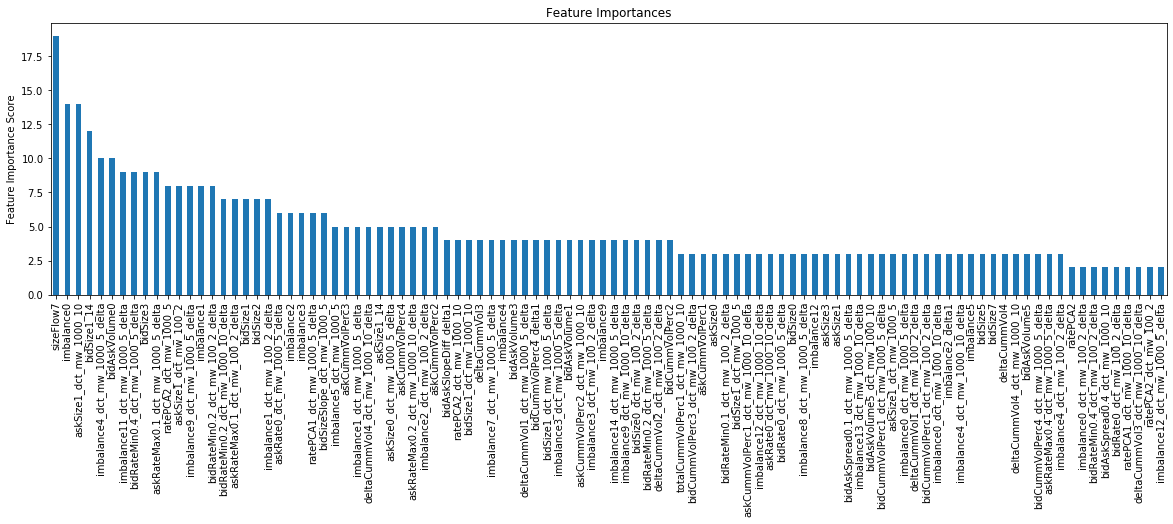

In [14]:
pylab.rcParams['figure.figsize'] = (20, 5)
modelfit(copy.deepcopy(xgb1), data_training, predictors, 'y')

In [15]:
xgb1_max = copy.deepcopy(xgb1)
xgb1_max.set_params(n_estimators=xgb1.n_estimators * 200)
xgb1_max.set_params(learning_rate=xgb1.learning_rate / 200)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.6, gamma=7,
       importance_type='gain', learning_rate=0.0005, max_delta_step=0,
       max_depth=5, min_child_weight=4000, missing=None,
       n_estimators=10000, n_jobs=8, nthread=None,
       objective='reg:squarederror', random_state=0, reg_alpha=0,
       reg_lambda=0.5, scale_pos_weight=1, seed=None, silent=None,
       subsample=0.8, verbosity=1)

sizeFlow7                             3948
imbalance0                            3199
bidSize1_14                           2747
askSize1_dct_mw_1000_10               2185
bidRateMin0.4_dct_mw_1000_5_delta     1830
bidAskVolume0                         1689
imbalance1                            1633
bidRateMin0.2_dct_mw_100_2_delta      1596
bidSize2                              1567
ratePCA2_dct_mw_1000_5                1533
imbalance3                            1353
imbalance11_dct_mw_1000_5_delta       1334
imbalance1_dct_mw_1000_5_delta        1313
bidSize1_dct_mw_1000_5                1294
bidSizeSlope_dct_mw_1000_5            1276
imbalance14_dct_mw_1000_5_delta       1259
bidRateMin0.2_dct_mw_1000_10_delta    1226
bidSize3                              1209
askSize1                              1184
askRateMax0.1_dct_mw_1000_5_delta     1183
dtype: int64
CPU times: user 1d 14h 42min 3s, sys: 1min 3s, total: 1d 14h 43min 7s
Wall time: 4h 50min 36s


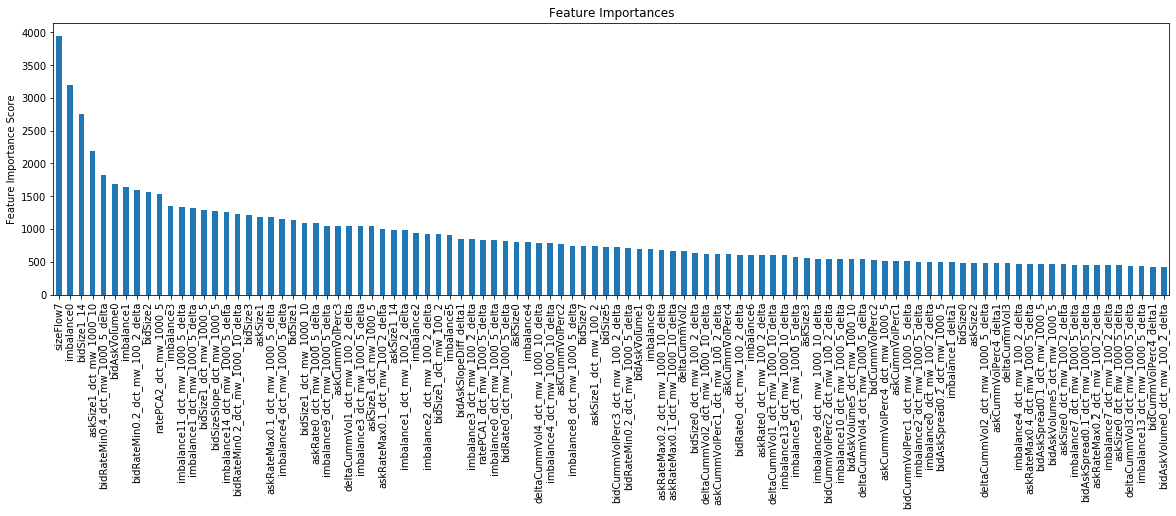

In [17]:
%%time

xgb1_fit = modelfit(xgb1_max, data_training, predictors, 'y')

pickle.dump(xgb1_fit, open("./core_models/xgb1.pkl", "wb"))
pickle.dump(predictors, open("./core_models/xgb1_columns.pkl", "wb"))

In [13]:
%%time

factor_data = 3

xgb1_full = copy.deepcopy(xgb1)
xgb1_full.set_params(subsample=xgb1.subsample / factor_data, 
                    n_jobs=8)

data_training_x = data_training_full.sample(frac=0.1 * factor_data, random_state=123).sort_index()

# print(model_wf_cv(xgb1_full, data_training_x, predictors, 'y', n_splits=3))

# (0.6932355462012247, 0.700076032953743, 0.023109892789449415)
# CPU times: user 48min 34s, sys: 51.2 s, total: 49min 26s
# Wall time: 7min 11s

# (0.6943158178875096, 0.7004448988161831, 0.02308543986972496)
# CPU times: user 51min 22s, sys: 1min 38s, total: 53min 1s
# Wall time: 15min 2s

CPU times: user 13.5 s, sys: 3.3 s, total: 16.8 s
Wall time: 15.6 s


In [15]:
params_n_estimators = {
    'n_estimators': [40, 50, 60, 70]
}

print(grid_search_rmse(copy.deepcopy(xgb1), data_training, predictors, 'y', 3, params_n_estimators))


{'n_estimators': 40}
	CV score test: 0.700240 (R2 0.022353)	CV score train: 0.693380
{'n_estimators': 50}
	CV score test: 0.700294 (R2 0.022203)	CV score train: 0.692007
{'n_estimators': 60}
	CV score test: 0.700301 (R2 0.022191)	CV score train: 0.690863
{'n_estimators': 70}
	CV score test: 0.700339 (R2 0.022087)	CV score train: 0.689728
(0.7002404413183707, {'n_estimators': 40})


In [16]:
del data_training

print(grid_search_rmse(copy.deepcopy(xgb1_full), data_training_x, predictors, 'y', 3, params_n_estimators))

{'n_estimators': 40}
	CV score test: 0.700383 (R2 0.023430)	CV score train: 0.695204
{'n_estimators': 50}
	CV score test: 0.700299 (R2 0.023670)	CV score train: 0.693989
{'n_estimators': 60}
	CV score test: 0.700401 (R2 0.023375)	CV score train: 0.692920
{'n_estimators': 70}


KeyboardInterrupt: 

sizeFlow7                            6589
imbalance0                           6053
bidSize1_14                          5293
askSize1_dct_mw_1000_10              4493
bidAskSlopeDiff_delta1               3666
bidAskVolume0                        3182
bidSizeSlope_dct_mw_1000_5           3035
askCummVolPerc3                      2838
bidSize3                             2824
imbalance1_dct_mw_1000_5_delta       2814
imbalance1                           2779
bidRateMin0.4_dct_mw_1000_5_delta    2759
imbalance4_dct_mw_1000_5_delta       2717
imbalance3_dct_mw_1000_5_delta       2615
ratePCA2_dct_mw_1000_5               2606
deltaCummVol1_dct_mw_100_2_delta     2590
bidSize1_dct_mw_1000_5               2549
askSize1                             2533
imbalance14_dct_mw_1000_5_delta      2475
askRateMax0.1_dct_mw_1000_5_delta    2456
dtype: int64
CPU times: user 9d 10h 56min 21s, sys: 6min, total: 9d 11h 2min 21s
Wall time: 1d 4h 24min 18s


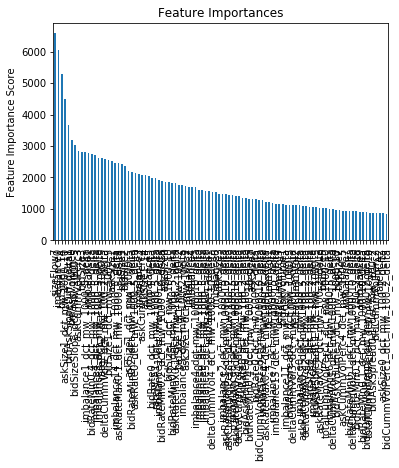

In [14]:
%%time

xgb1_full.set_params(n_estimators=xgb1.n_estimators * 400)
xgb1_full.set_params(learning_rate=xgb1.learning_rate / 400)

xgb1_full_fit = modelfit(xgb1_full, data_training_x, predictors, 'y')

pickle.dump(xgb1_full_fit, open("./core_models/xgb1_3x_400.pkl", "wb"))
pickle.dump(predictors, open("./core_models/xgb1_columns.pkl", "wb"))